In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch.nn as nn 
import random
import torch
import torch.optim as optim 
from collections import deque,namedtuple
import warnings
from collections import OrderedDict
warnings.filterwarnings('ignore')#выключаем системные предупреждения

In [2]:
sity_num=650#городов в эпохе - переменная использовалась при тестировании
ep=15#кол-во эпох
#настройки сети
dis_fuc = 0.99
TAU = 1e-4
SN_WEIGHT = 1e-4
LR_CR = 5e-4
LR_AC = 1e-4 
MEM_SIZE = int(1e6)

In [3]:
data=pd.read_csv('cities.csv', encoding='cp1251')
data.head()

,Город,Страна,lat,lng,Население,Аб2,Аб3
0,Токио,Япония,35.6839,139.7744,39105000.0,JP,JPN
1,Джакарта,Индонезия,-6.2146,106.8451,35362000.0,ID,IDN
2,Дели,Индия,28.6667,77.2167,31870000.0,IN,IND
3,Манила,Филиппины,45091,120.9833,23971000.0,PH,PHL
4,Сан-Паулу,Бразилия,-23.5504,-46.6339,22495000.0,BR,BRA


In [4]:
data['Страна'].value_counts()

Соединенные Штаты                             7824
Бразилия                                      3604
Германия                                      2643
Италия                                        2140
Франция                                       2019
                                              ... 
Бермудские острова                               1
Западный берег                                   1
Северные Марианские острова                      1
Фолклендские острова (Мальвинские острова)       1
Виргинские острова США                           1
Name: Страна, Length: 238, dtype: int64

In [5]:
cites=pd.DataFrame(data['Город'].unique(),columns=['name'])
cites

,name
0,Токио
1,Джакарта
2,Дели
3,Манила
4,Сан-Паулу
...,...
38633,Тукчи
38634,Нумто
38635,Норд
38636,Тиммиармиут


In [6]:
cites=cites[cites.name.apply(lambda x: True if (re.fullmatch(r'[а-яА-ЯёЁ][а-яА-ЯёЁ\s\'-]+[а-яА-ЯёЁ]', str(x))) else False)]
cites

,name
0,Токио
1,Джакарта
2,Дели
3,Манила
4,Сан-Паулу
...,...
38633,Тукчи
38634,Нумто
38635,Норд
38636,Тиммиармиут


In [7]:
cites.isnull().sum()

name    0
dtype: int64

In [8]:
cites['first']=cites['name'].str[0].str.lower()
f_unique=cites['first'].unique()
print(f_unique)
cites['last']='0'#cites['name'].str[-1].str.lower()
cites['active']=True

#Ищем букву входящую в число букв с которых начинаются названия городов
def f(row, f_unique):
    i=-1
    lett=row['last']
    while True:
        if lett in f_unique:
            break
        else:
            lett=row['name'][i].lower()
            i-=1
    return lett


cites['last']=cites.apply(f, axis=1,f_unique=f_unique)
cites

['т' 'д' 'м' 'с' 'ш' 'г' 'к' 'п' 'н' 'б' 'е' 'л' 'х' 'р' 'ч' 'у' 'в' 'ф'
 'ц' 'а' 'я' 'ю' 'и' 'й' 'ж' 'о' 'э' 'з' 'щ' 'ы']


,name,first,last,active
0,Токио,т,о,True
1,Джакарта,д,а,True
2,Дели,д,и,True
3,Манила,м,а,True
4,Сан-Паулу,с,у,True
...,...,...,...,...
38633,Тукчи,т,и,True
38634,Нумто,н,о,True
38635,Норд,н,д,True
38636,Тиммиармиут,т,т,True


In [9]:
stat=cites['name'].str[-1].str.lower()!=cites['last']
print(sum(stat))
cites[stat]

945


,name,first,last,active
23,Шэньчжэнь,ш,н,True
35,Тяньцзинь,т,н,True
41,Ухань,у,н,True
49,Туншань,т,н,True
57,Дунгуань,д,н,True
...,...,...,...,...
38275,Аулумаль,а,л,True
38342,Дженерал Левалль,д,л,True
38373,Жэньчжуанцунь,ж,н,True
38378,Хэцзячуань,х,н,True


In [10]:
cites[stat]['name'].str[-1].str.lower().value_counts()

ь    942
ё      3
Name: name, dtype: int64

In [11]:
cites['first'].value_counts()

с    3711
к    3693
б    2901
м    2665
п    2166
а    1917
л    1786
т    1786
в    1745
д    1569
г    1474
н    1294
р    1166
х    1153
ф     824
о     822
и     812
э     763
у     674
ч     651
ш     549
з     441
ц     253
ю     206
я     198
е     101
ж      86
й      74
щ      10
ы       1
Name: first, dtype: int64

In [12]:
cites[cites['first']=='ы']#Просто заинтересовал город на "ы"

,name,first,last,active
33365,Ытык-Кюёль,ы,л,True


In [13]:
cites['transf']=cites['first']+cites['last']
stat=pd.merge(cites['last'].value_counts(), cites['first'].value_counts(), left_index=True, right_index=True).sort_index()
stat['last/first']=stat['last']/stat['first']
stat

,last,first,last/first
а,5778,1917,3.014085
б,102,2901,0.035160
в,268,1745,0.153582
г,1155,1474,0.783582
д,989,1569,0.630338
е,1885,101,18.663366
ж,211,86,2.453488
з,240,441,0.544218
и,2867,812,3.530788
й,881,74,11.905405


Text(0.5, 1.0, 'Количество букв в начале и в конце')

<Figure size 1500x1200 with 0 Axes>

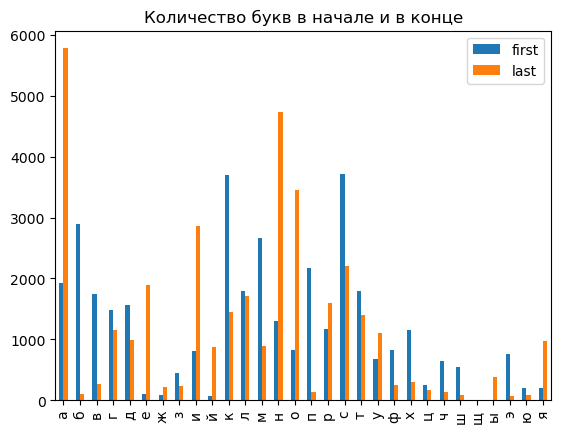

In [14]:
fig = plt.figure(figsize =(15, 12))
stat[['first','last']].plot.bar();
plt.title('Количество букв в начале и в конце')

Text(0.5, 1.0, 'Процентное разбиение первых букв')

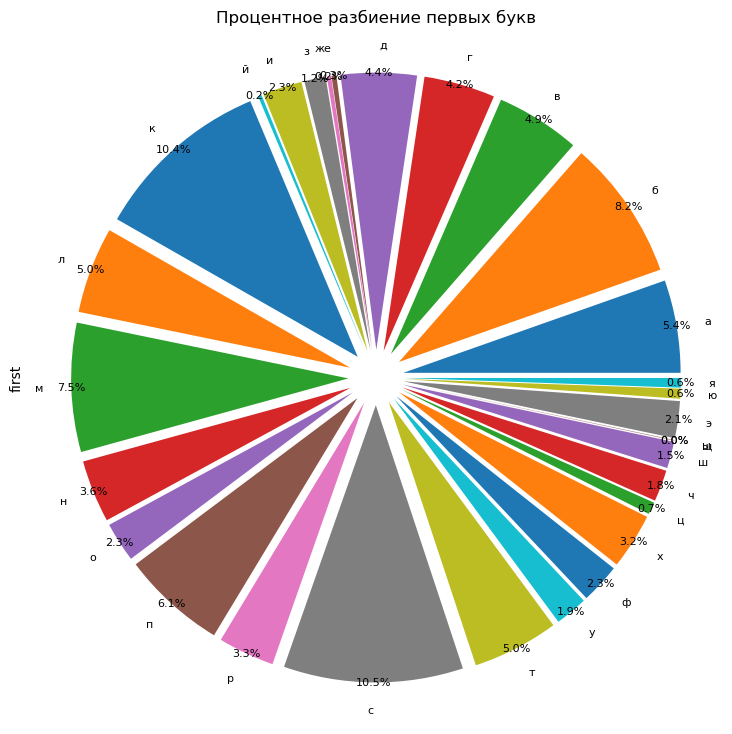

In [15]:
plt.figure(figsize =(12, 9))
stat['first'].plot.pie(autopct='%1.1f%%',pctdistance=1,explode=[0.1 for i in range (stat.shape[0])], textprops={'fontsize': 8});
plt.title('Процентное разбиение первых букв')

Text(0.5, 1.0, 'Процентное разбиение последних букв')

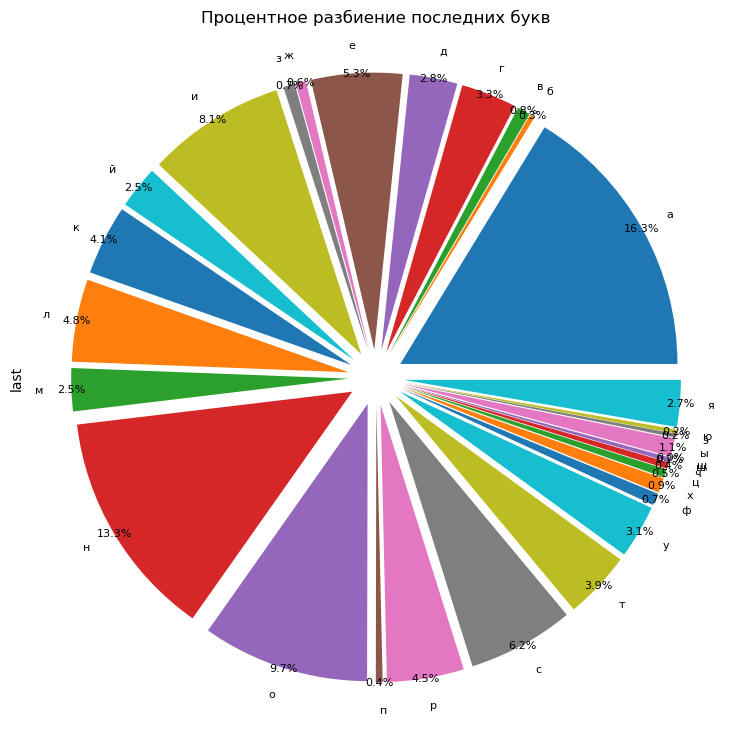

In [16]:
plt.figure(figsize =(12, 9))
stat['last'].plot.pie(autopct='%1.1f%%',pctdistance=1,explode=[0.1 for i in range (stat.shape[0])], textprops={'fontsize': 8});
plt.title('Процентное разбиение последних букв')

In [17]:
stat=pd.DataFrame((cites['transf']).value_counts().sort_index())
letters=stat.index

start_last=pd.DataFrame(stat.index,index=stat.index)#,columns=['transf'])

start_last['first']=start_last[0].str[0]
#'''
start_last['last']=start_last[0].str[1]
start_last=start_last.drop(0, axis=1)
#'''
for i in (['first','last']):
    k=start_last[i].unique()
    start_last=start_last.join(pd.get_dummies(start_last[i]))#.drop(i, axis=1)
    for ii in (k):
        start_last=start_last.rename(columns={ii: i+"_"+ii})
#'''
#start_last=start_last.drop('last', axis=1)
start_last#'''

,first,last,first_а,first_б,first_в,first_г,first_д,first_е,first_ж,first_з,...,last_ф,last_х,last_ц,last_ч,last_ш,last_щ,last_ы,last_э,last_ю,last_я
аа,а,а,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
аб,а,б,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ав,а,в,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
аг,а,г,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ад,а,д,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
яф,я,ф,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
яц,я,ц,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
яэ,я,э,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
яю,я,ю,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
class Environment():
    def __init__(self, cites, start_last, apendd=False):
        #Последняя буква последнего названия города. False - любая (для начала игры) 
        self.prev_letter=False
        #Техническо-костыльное значение.
        self.cites=cites.append(pd.DataFrame({'name': ['Уже использован'], 'first': ['%'],'active':[False]}), ignore_index = True)
        self.apendd=apendd
        self.start_last=start_last
    def reset(self):
        self.cites['active']=self.cites["name"]!="Уже использован"
        self.prev_letter=False
    def cites_updet(self,cites):
        self.cites=cites.append(pd.DataFrame({'name': ['Уже использован'], 'first': ['%'],'active':[False]}), ignore_index = True)
    def step(self,city):
        done=False
        reward=-0.005#0.05
        inf=''
        if self.prev_letter==False or city[0].lower()==self.prev_letter:
            cit=self.cites[self.cites["name"] == city]
            if cit.shape[0]>0:
                if cit["active"].iloc[0]:
                    self.prev_letter=cit['last'].iloc[0]
                    self.cites["active"][self.cites["name"] == city]=False
                else:
                    done=True
                    reward=-100
                    inf='Повторное использование города'
                    print()
            elif self.apendd:
                self.cites.append(f(pd.DataFrame({'name': [city], 'first': [city[0].lower()], 'last': [city[-1]],'active':[False]}), f_unique), ignore_index = True)
                self.prev_letter=self.cites[self.cites["name"] == city]['last']
            else:
                done=True
                reward=-100
                inf='Введённое значение не является городом'
                print(inf)
        else:
            done=True
            reward=-100
            inf='Не правильная первая буква.'
            print(inf,'Город:',city,'Искомая буква',self.prev_letter)
        return(reward,done,inf)
    def stat(self):
        zam=100
        cit=pd.concat([self.start_last,self.cites[self.cites["active"]]['transf'].value_counts()], axis=1, join='outer')
        t=cit.groupby('first').sum()["transf"]
        t=pd.DataFrame({'lastt':t.index,'last_let_av':t.values})
        cit=cit.merge(t,left_on='last',right_on='lastt',how='outer')
        cit=cit.sort_values(by=['first','last'])
        cit=cit.drop('last', axis=1).drop('lastt', axis=1)
        if self.prev_letter:
            cit['first']=(cit['first']==self.prev_letter)*zam
        else:
            cit['first']=zam
        cit['transf']=(1-cit['transf']/cit['transf'].max())#*1.5#*10#1-
        cit['transf']=cit['transf'].fillna(-zam)
        cit['last_let_av']=cit['last_let_av'].fillna(0)
        cit['last_let_av']=(1-cit['last_let_av']/cit['last_let_av'].max())/2#*1.5
        return cit
    def with_letter(self, letters):
        cit=self.cites[(self.cites["active"])&(self.cites["first"]==letters[0])&(self.cites["last"]==letters[1])]
        if cit.shape[0]>0:
            cit=cit.sample(n=1).name.values[0]
        else:
            cit="Уже использован"
        return cit

In [20]:
env=Environment(cites, start_last)
env.stat()

,first,first_а,first_б,first_в,first_г,first_д,first_е,first_ж,first_з,first_и,...,last_ц,last_ч,last_ш,last_щ,last_ы,last_э,last_ю,last_я,transf,last_let_av
0,100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.354037,0.241714
28,100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.982919,0.109135
50,100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.984472,0.264888
76,100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.916149,0.301401
104,100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.933230,0.288601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.998447,0.388979
618,100,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.998447,0.465912
709,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.995342,0.397198
732,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.996894,0.472245


In [21]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, hid_units=256):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hid_units)
        #self.relu = nn.ReLU()# Ч
        self.drout = nn.Dropout(p=0.5, inplace=False)
        self.fc2 = nn.Linear(hid_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(0, 1e-4)

    def forward(self, state):
        #state = self.drout(self.relu(self.fc1(state)))
        state = self.drout((self.fc1(self.drout(state))))
        return nn.functional.tanh(self.fc2(state))

In [22]:
class MemoryCls:
    def __init__(self, action_size, mem_size, seed):
        self.mem_size=mem_size
        self.action_size = action_size
        self.memory = deque(maxlen=mem_size) 
        self.experience = namedtuple("Experience", field_names=["states", "action", "reward", "next_states", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        states = torch.from_numpy(np.vstack([e.states for e in self.memory if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in self.memory if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in self.memory if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_states for e in self.memory if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in self.memory if e is not None]).astype(np.uint8)).float().to(device)
        self.memory = deque(maxlen=self.mem_size)
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.memory)



In [23]:
class Agent():
    def __init__(self, state_size, action_size, random_seed, bsize,MEM_SIZE,LR_AC,SN_WEIGHT,dis_fuc):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        #Память
        self.memory = MemoryCls(action_size, MEM_SIZE, random_seed)
        self.dis_fuc=dis_fuc
        #Актёр
        self.actish = Actor(state_size, action_size, random_seed).to(device)
        self.actor_fi = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actish.parameters(), lr=LR_AC)
        #Критик
        self.critic_local = Critic(state_size, action_size, random_seed, bsize=bsize).to(device)
        self.critic_fi = Critic(state_size, action_size, random_seed, bsize=bsize).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CR, weight_decay=SN_WEIGHT)
    def change_bsize(self, bsize):#смена размера поля. В текущей версии использовалось лишь для текстов
        self.critic_local.bsize=bsize
        self.critic_fi.bsize=bsize
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        #В образце работали с передвижением объекта, поэтому там обучение шло по прошествию определённого интервала в ходах.
        #Здесь же лучше себя показала тактика с разбиением на отдельные игры и обучением после конца каждой игры
        if done:
            self.learn(self.memory.sample())
    def act(self, state):#Непосредственно получение реакции на ситуацию (state)
        state = torch.from_numpy(state.to_numpy().astype(np.float32)).float().to(device)
        self.actish.eval()
        with torch.no_grad():
            action = self.actish(state).cpu().data.numpy()
        self.actish.train()
        
        return action
    def learn(self,mem_l):#Запоминание результатов
        states, actions, rewards, next_states, dones = mem_l
        actions_next = self.actor_fi(next_states)
        Q_fis_next = self.critic_fi(next_states, actions_next)
        Q_fis = rewards + (self.dis_fuc * Q_fis_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = nn.functional.mse_loss(Q_expected, Q_fis)
        self.critic_optimizer.zero_grad()
        critic_loss.requires_grad = True
        critic_loss.backward()
        self.critic_optimizer.step()
        actions_pred = self.actish(states)
        actor_loss = -self.critic_local(states, actions_pred).type(torch.FloatTensor).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.requires_grad = True
        actor_loss.backward()
        self.actor_optimizer.step()
        self.soft_update(self.critic_local, self.critic_fi, TAU,['fcs1.weight', 'fcs1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight','fc4.bias'])
        self.soft_update(self.actish, self.actor_fi, TAU,['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias']) 
    def soft_update(self, act_model, cel_model, tau,names):#Обновление весов
        ordered_list = []#Для костыльного метода обновления, так как тот же что и у остальных не работает
        i=0
        with torch.no_grad():
            for cel_param, act_param in zip(cel_model.parameters(), act_model.parameters()):
                ordered_list.append((names[i],act_param.data.copy_(act_param.data + (1.0-tau)*cel_param.data)))
                i+=1
        act_model.load_state_dict(OrderedDict(ordered_list))
        

In [24]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, bsize,fcs1_units=256, fc2_units=256, fc3_units=128):
        self.bsize=bsize
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(0, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = nn.functional.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = nn.functional.leaky_relu(self.fc2(x))
        x = nn.functional.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        x = x.split(self.bsize)
        x = torch.stack(list(x), dim=0)
        return torch.argmax(x, dim=1)

In [25]:

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (0, lim)

def ddpg(n_episodes=1):
    steps_ar=[]
    cites_ar=[]
    inf_ar=[]
    for i_episode in range(n_episodes):
        env.reset()
        steps=0
        city_list=[]
        while True:
            player=steps%2
            steps+=1
            state = env.stat()
            action = agent[player].act(state)
            city_name=env.with_letter(letters[np.argmax(np.sum(action,axis=1))])
            city_list.append(city_name)
            reward, done, inf = env.step(city_name)
            #Присвоение награды откладывается на один ход, так как если оппонент на этом ходу проиграет, то стандартный штраф
            #предназначенный для стимуляции сокращения кол-ва ходов в партии, заменяется на награду за победу
            if done:
                agent[(player+1)%2].step(prev_state,prev_action, -reward,  env.stat(), done)
                #agent[player].step(state,action, (reward+min(steps,49)), env.stat(), done)
                agent[player].step(state,action, reward, env.stat(), done)
                break
            elif steps>1:
                agent[(player+1)%2].step(prev_state, prev_action, reward,  env.stat(), done)
            
            prev_action=action
            prev_state = state
        
        #agent[0].actish.state_dict()
        #agent[1].actish.state_dict()
        inf_ar.append(inf)
        steps_ar.append(steps)
        cites_ar.append(city_list)
        print('\n\nЭпизод',i_episode,' Шаг завершения игры:',steps,'Количество городов начинающихся на искомую букву (в идеале = 0):',sum(env.stat()['first']==1),'\nГорода: ','->'.join(city_list))
        agent[0], agent[1] = agent[1], agent[0]
    return(steps_ar,cites_ar,inf_ar,agent)


env=Environment(cites, start_last)
stat_sz=env.stat().shape[1]
agent = [Agent(state_size=stat_sz,action_size=start_last.shape[0], random_seed=10,bsize=env.stat().shape[0],MEM_SIZE=MEM_SIZE,LR_AC=LR_AC,SN_WEIGHT=SN_WEIGHT,dis_fuc=dis_fuc),#start_last.shape[0]),
         Agent(state_size=stat_sz,action_size=start_last.shape[0], random_seed=10,bsize=env.stat().shape[0],MEM_SIZE=MEM_SIZE,LR_AC=LR_AC,SN_WEIGHT=SN_WEIGHT,dis_fuc=dis_fuc)]#start_last.shape[0])]



steps_ar,cites_ar,inf_ar,agent=ddpg(ep)


Не правильная первая буква. Город: Уже использован Искомая буква ы


Эпизод 0  Шаг завершения игры: 17 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Щучье->Е полностью->Юпилтепеке->ЕСитиЕЙте->Е Марджейке Топлице->Естествознание->Елч-Ласковице->Енице->Е Марье->Егуновце->Есенице->Е Венецианцы->Ытык-Кюёль->Лейквью->Юрбизе->Е счеты->Уже использован
Не правильная первая буква. Город: Уже использован Искомая буква ы


Эпизод 1  Шаг завершения игры: 17 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Щучье->Е полностью->Юрбизе->Естествознание->Енице->ЕСитиЕЙте->Е Марджейке Топлице->Елч-Ласковице->Е Марье->Есенице->Егуновце->Е Венецианцы->Ытык-Кюёль->Лейси-Лейквью->Юпрелле->Е счеты->Уже использован
Не правильная первая буква. Город: Уже использован Искомая буква ы


Эпизод 2  Шаг завершения игры: 17 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Щучье->Е полностью->Юпрелле->Елч-Ласковице->Е Марджейке Топли

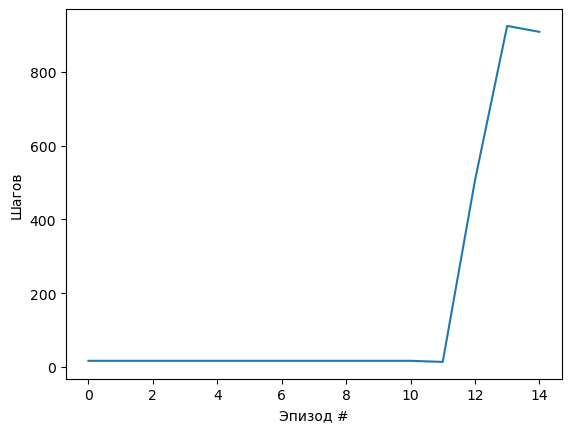

In [26]:
fig = plt.figure()
plt.plot(np.arange(ep), steps_ar)
plt.ylabel('Шагов')
plt.xlabel('Эпизод #')
plt.show()

Text(0.5, 1.0, 'Процентное разбиение причин завершения игры')

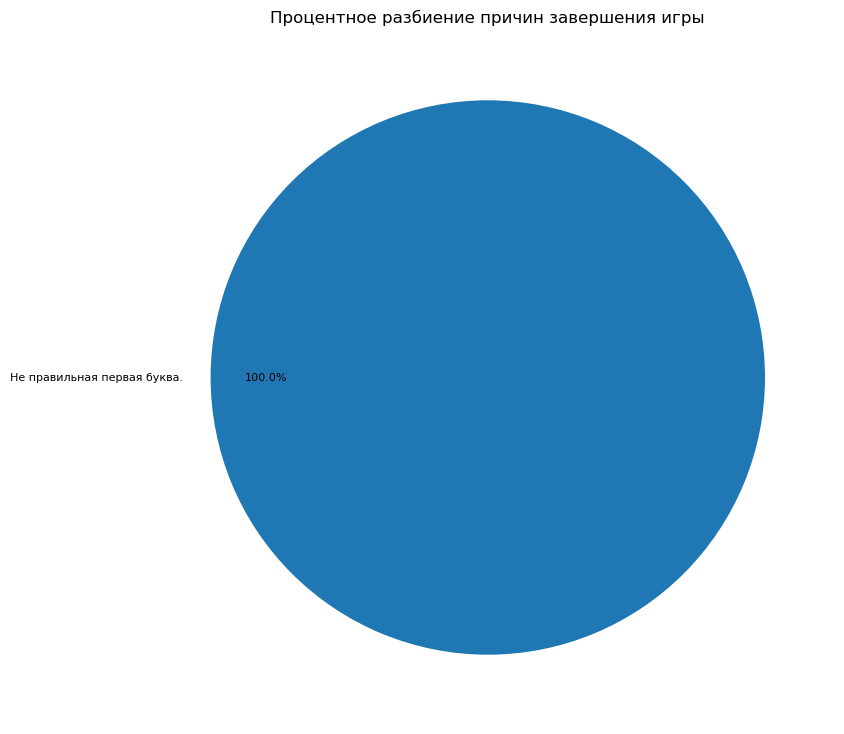

In [27]:
plt.figure(figsize =(12, 9))
pd.Series(inf_ar).value_counts().plot.pie(autopct='%1.1f%%',pctdistance=0.8, textprops={'fontsize': 8});
plt.title('Процентное разбиение причин завершения игры')

In [28]:
env.stat()[env.stat()['first']!=0]

,first,first_а,first_б,first_в,first_г,first_д,first_е,first_ж,first_з,first_и,...,last_ц,last_ч,last_ш,last_щ,last_ы,last_э,last_ю,last_я,transf,last_let_av
318,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-100.0,0.259649


In [29]:
env=Environment(cites[:sity_num], start_last)

agent = [Agent(state_size=stat_sz,action_size=start_last.shape[0], random_seed=10,bsize=env.stat().shape[0],MEM_SIZE=MEM_SIZE,LR_AC=LR_AC,SN_WEIGHT=SN_WEIGHT,dis_fuc=dis_fuc),#start_last.shape[0]),
         Agent(state_size=stat_sz,action_size=start_last.shape[0], random_seed=10,bsize=env.stat().shape[0],MEM_SIZE=MEM_SIZE,LR_AC=LR_AC,SN_WEIGHT=SN_WEIGHT,dis_fuc=dis_fuc)]#start_last.shape[0])]



steps_ar,cites_ar,inf_ar,agent=ddpg(ep)


Не правильная первая буква. Город: Уже использован Искомая буква е


Эпизод 0  Шаг завершения игры: 12 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Кебе->ЕСака->Ахваз->Звенящий->Йоханнесбург->Громче->Екатеринбург->Гойня->Янше->Ереван->Нинде->Уже использован
Не правильная первая буква. Город: Уже использован Искомая буква е


Эпизод 1  Шаг завершения игры: 12 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Кебе->ЕСака->Ахваз->Звенящий->Йоханнесбург->Громче->Екатеринбург->Гойня->Янше->Ереван->Нинде->Уже использован
Не правильная первая буква. Город: Уже использован Искомая буква е


Эпизод 2  Шаг завершения игры: 12 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Кебе->ЕСака->Ахваз->Звенящий->Йоханнесбург->Громче->Екатеринбург->Гойня->Янше->Ереван->Нинде->Уже использован
Не правильная первая буква. Город: Уже использован Искомая буква е


Эпизод 3  Шаг завершения игры: 12 Количество городов начинающ

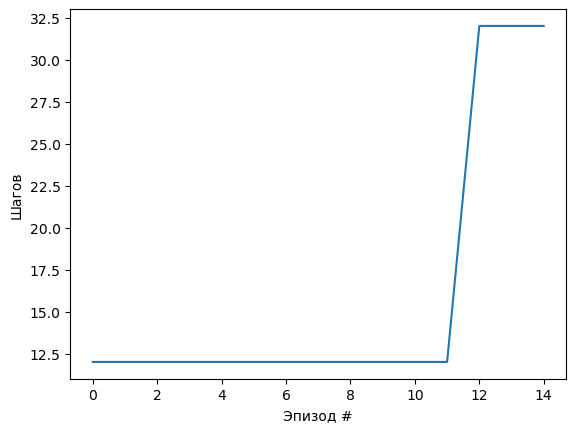

In [30]:
fig = plt.figure()
#ax = fig.add_subplot(111)
plt.plot(np.arange(ep), steps_ar)
plt.ylabel('Шагов')
plt.xlabel('Эпизод #')
plt.show()

Text(0.5, 1.0, 'Процентное разбиение причин завершения игры')

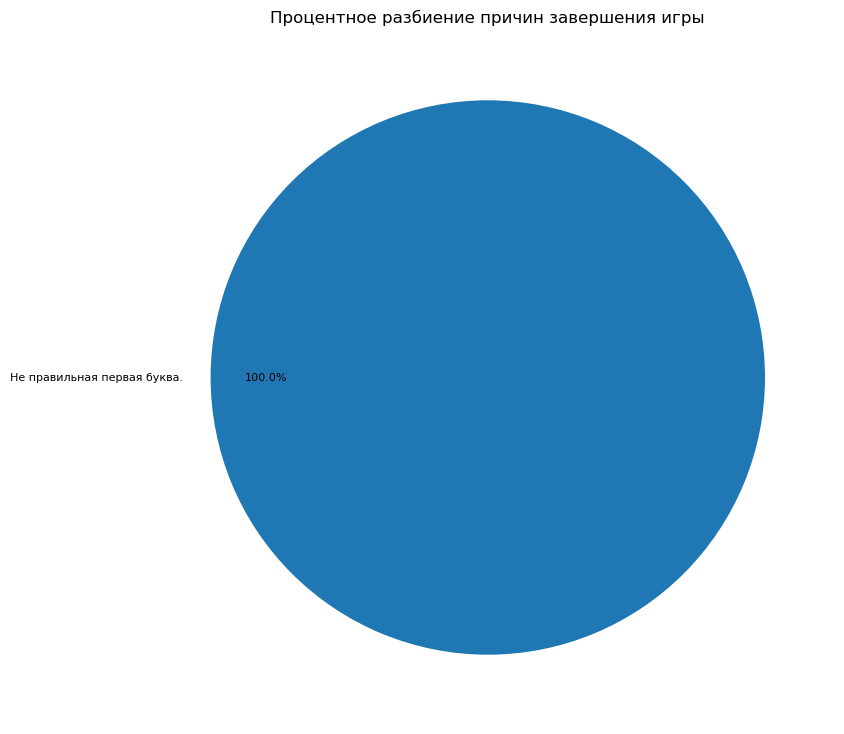

In [31]:
plt.figure(figsize =(12, 9))
pd.Series(inf_ar).value_counts().plot.pie(autopct='%1.1f%%',pctdistance=0.8, textprops={'fontsize': 8});
plt.title('Процентное разбиение причин завершения игры')

In [32]:
env.stat()[env.stat()['first']!=0]

,first,first_а,first_б,first_в,first_г,first_д,first_е,first_ж,first_з,first_и,...,last_ц,last_ч,last_ш,last_щ,last_ы,last_э,last_ю,last_я,transf,last_let_av
9,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-100.0,0.432203
85,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-100.0,0.254237
113,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-100.0,0.228814
141,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-100.0,0.483051
217,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-100.0,0.398305
245,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-100.0,0.500000
274,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-100.0,0.118644
302,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-100.0,0.186441
331,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-100.0,0.067797
359,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-100.0,0.330508
